In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
T=100
dt=1
Boundary=6
signal_noise_ratio = 0.2

In [6]:
def generate_trajectory():
    x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, 1, Boundary)
    STATEs = np.zeros((T+1, 4))
    Disps = np.zeros((T, 2))
    init_state = np.array([x0[0], y0[0], init_v_rand_dir[0, 0], init_v_rand_dir[0, 1]])

    STATEs, Disps, _ = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)
    return STATEs, Disps

In [7]:
import os.path

if os.path.isfile('examples/dynamical_ball/trajectory.data'):
    trajectory_dict = torch.load('examples/dynamical_ball/trajectory.data')
    STATEs = trajectory_dict['STATEs']
    Disps = trajectory_dict['Disps']
else:
    STATEs, Disps = generate_trajectory()
    STATEs = torch.tensor(STATEs, dtype=torch.float32)
    Disps = torch.tensor(Disps, dtype=torch.float32)
    trajectory_dict = {
        'STATEs': STATEs,
        'Disps': Disps,
    }
    torch.save(trajectory_dict, 'examples/dynamical_ball/trajectory.data')

In [8]:
def generate_trajectory_trace():
    trajectory = STATEs
    displacements = Disps

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = point[:2]
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [9]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [10]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [11]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [12]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [13]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [14]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [15]:
def generative_model(num_particles):
    init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)
    bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(bouncing_ball_step, initializer=init_bouncing_ball),
                           lambda: range(T))

In [16]:
def attach_proposal(model, guide, inclusive_kl=False):
    if inclusive_kl:
        return importance.Propose(guide, model)
    else:
        return importance.Propose(model, guide)

In [17]:
def recognition_model(num_particles, fold=True):
    init_bouncing_ball = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    bouncing_ball_step = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    if fold:
        return foldable.Reduce(foldable.Step(bouncing_ball_step, initializer=init_bouncing_ball),
                               lambda: range(T))
    return init_bouncing_ball, bouncing_ball_step

In [18]:
def attach_proposals(model, num_particles, inclusive_kl=False):
    if inclusive_kl:
        inference_model = recognition_model(num_particles, True)
        return attach_proposal(model, inference_model, inclusive_kl)
    else:
        init_proposal, step_proposal = recognition_model(num_particles, False)

        init_selector = lambda m: m.name == 'InitBallDynamics'
        init_attach = lambda m: attach_proposal(m, init_proposal, inclusive_kl)
        model = model.apply(init_attach, init_selector)

        step_selector = lambda m: m.name == 'StepBallDynamics'
        step_attach = lambda m: attach_proposal(m, step_proposal, inclusive_kl)
        return model.apply(step_attach, step_selector)

In [19]:
def training_model(num_particles, inference_strategy, inclusive_kl=False):
    model = generative_model(num_particles)
    if inclusive_kl:
        return attach_proposals(inference_strategy(model), num_particles, True)
    else:
        model = attach_proposals(model, num_particles, inclusive_kl)
        model = inference_strategy(model)
        return model

In [20]:
trajectory, displacements, data = generate_trajectory_trace()

In [21]:
def train_model(num_particles, inference_strategy, inclusive_kl=False, plot_bounds=True):
    sampler = training_model(num_particles, inference_strategy, inclusive_kl=inclusive_kl)
    
    tau, params, evidence_bounds = importance.variational_importance(
        sampler, 100, data, use_cuda=True, lr=1e-1,
        inclusive_kl=inclusive_kl, patience=100,
    )
    
    if plot_bounds:
        utils.plot_evidence_bounds(evidence_bounds, not inclusive_kl)
    
    return sampler, tau, evidence_bounds

In [22]:
def evaluate_inference(sampler, tau):
    inferred_trajectory = accumulate_trajectory(tau)

    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([tau['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)

    graph_original_trajectory(trajectory, T, 0)
    graph_inferred_trajectory(positions, T, 0)
    graph_displacement_trajectories(velocity_steps, displacements, T, 0)
    
    for t in range(T+1):
        logging.info('MSE at time %d: %s' % (t, ((data['position_%d' % t] - positions[t])**2).sum(dim=0)))

In [23]:
sample_sizes = [2, 10, 100]
SAMPLING_STRATEGIES = ['Importance weighting', 'Sequential Monte Carlo', 'Resample-Move Sequential Monte Carlo']
sampling_strategies = [lambda m: m, lambda m: importance.step_smc(m), lambda m: mcmc.step_resample_move_smc(m, moves=5)]
kl_directions = [False, True]

In [24]:
def experiment():
    results = {}
    for i, inference_strategy in enumerate(sampling_strategies):
        for inclusive_kl in kl_directions:
            for num_particles in sample_sizes:
                logging.info('Experimenting with sampling strategy: ' + SAMPLING_STRATEGIES[i])
                logging.info('Experimenting with sample size of %d', num_particles)
                logging.info('Experimenting with %s training', 'Wake-Sleep' if inclusive_kl else 'Variational')
                sampler, tau, evidence_bounds = train_model((num_particles,), inference_strategy, inclusive_kl, plot_bounds=True)
                evaluate_inference(sampler, tau)
                results[(SAMPLING_STRATEGIES[i], num_particles, inclusive_kl)] = (tau, evidence_bounds)
    return results

03/01/2019 18:03:41 Experimenting with sampling strategy: Importance weighting
03/01/2019 18:03:41 Experimenting with sample size of 2
03/01/2019 18:03:41 Experimenting with Variational training
03/01/2019 18:03:42 ELBO=-4.71104950e+02 at epoch 1
03/01/2019 18:03:42 ELBO=-5.36583435e+02 at epoch 2
03/01/2019 18:03:42 ELBO=-5.71888794e+02 at epoch 3
03/01/2019 18:03:42 ELBO=-4.40770905e+02 at epoch 4
03/01/2019 18:03:43 ELBO=-6.42878967e+02 at epoch 5
03/01/2019 18:03:43 ELBO=-5.03230988e+02 at epoch 6
03/01/2019 18:03:43 ELBO=-9.06987976e+02 at epoch 7
03/01/2019 18:03:43 ELBO=-5.10911713e+02 at epoch 8
03/01/2019 18:03:43 ELBO=-4.20216736e+02 at epoch 9
03/01/2019 18:03:43 ELBO=-4.83726929e+02 at epoch 10
03/01/2019 18:03:43 ELBO=-4.72426422e+02 at epoch 11
03/01/2019 18:03:44 ELBO=-4.51946991e+02 at epoch 12
03/01/2019 18:03:44 ELBO=-4.51394806e+02 at epoch 13
03/01/2019 18:03:44 ELBO=-4.19455719e+02 at epoch 14
03/01/2019 18:03:44 ELBO=-4.21957794e+02 at epoch 15
03/01/2019 18:03:44

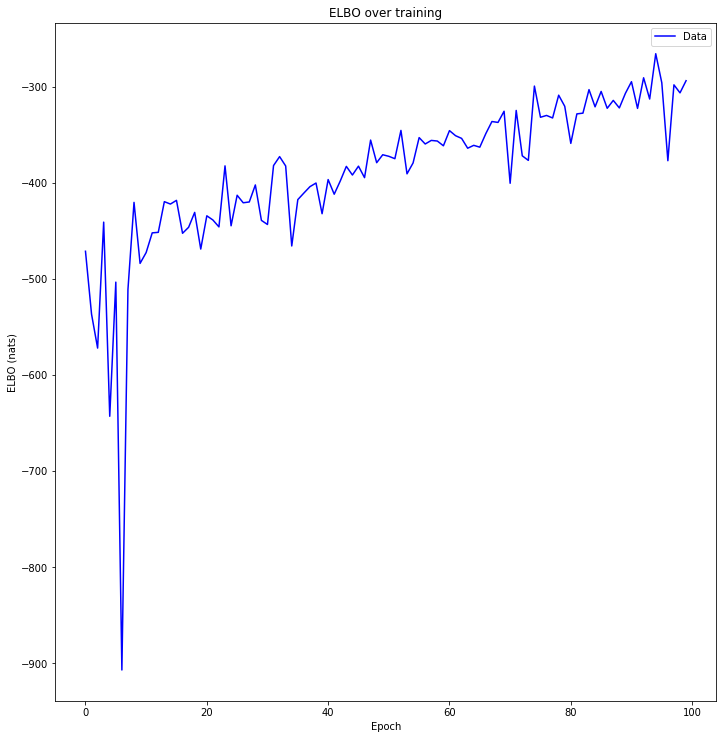

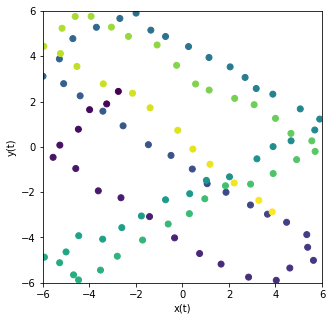

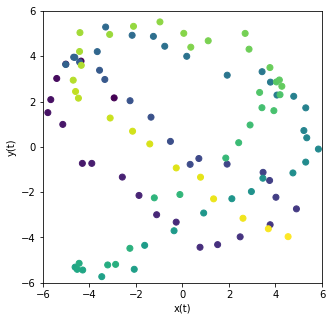

03/01/2019 18:03:58 MSE at time 0: tensor(0.1152)
03/01/2019 18:03:58 MSE at time 1: tensor(4.7916)
03/01/2019 18:03:58 MSE at time 2: tensor(5.0952)
03/01/2019 18:03:58 MSE at time 3: tensor(5.8887)
03/01/2019 18:03:58 MSE at time 4: tensor(4.1903)
03/01/2019 18:03:58 MSE at time 5: tensor(3.9438)
03/01/2019 18:03:58 MSE at time 6: tensor(4.1049)
03/01/2019 18:03:58 MSE at time 7: tensor(1.9386)
03/01/2019 18:03:58 MSE at time 8: tensor(3.8760)
03/01/2019 18:03:58 MSE at time 9: tensor(4.4127)
03/01/2019 18:03:58 MSE at time 10: tensor(5.8518)
03/01/2019 18:03:58 MSE at time 11: tensor(6.3481)
03/01/2019 18:03:58 MSE at time 12: tensor(7.1577)
03/01/2019 18:03:58 MSE at time 13: tensor(6.1010)
03/01/2019 18:03:58 MSE at time 14: tensor(8.8448)
03/01/2019 18:03:58 MSE at time 15: tensor(6.4555)
03/01/2019 18:03:58 MSE at time 16: tensor(5.9420)
03/01/2019 18:03:58 MSE at time 17: tensor(3.1081)
03/01/2019 18:03:58 MSE at time 18: tensor(4.4790)
03/01/2019 18:03:58 MSE at time 19: tenso

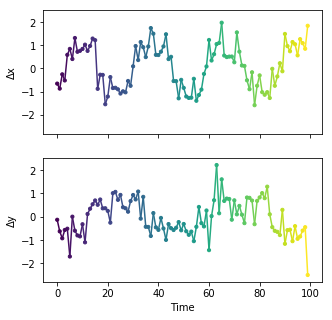

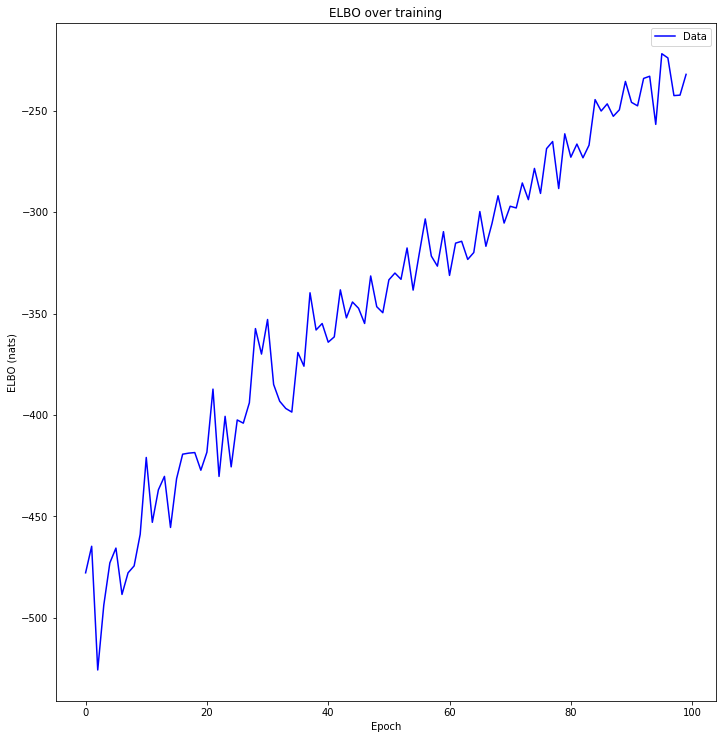

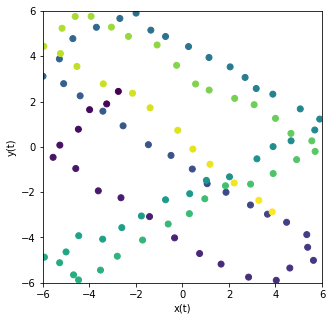

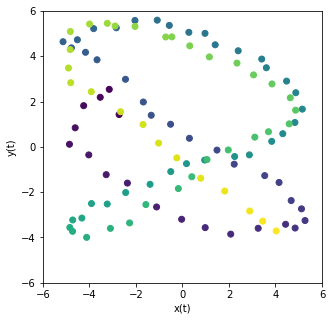

03/01/2019 18:04:15 MSE at time 0: tensor(1.0449)
03/01/2019 18:04:15 MSE at time 1: tensor(0.4245)
03/01/2019 18:04:15 MSE at time 2: tensor(0.5089)
03/01/2019 18:04:15 MSE at time 3: tensor(1.1317)
03/01/2019 18:04:15 MSE at time 4: tensor(1.0212)
03/01/2019 18:04:15 MSE at time 5: tensor(0.8265)
03/01/2019 18:04:15 MSE at time 6: tensor(0.6735)
03/01/2019 18:04:15 MSE at time 7: tensor(0.6236)
03/01/2019 18:04:15 MSE at time 8: tensor(0.4944)
03/01/2019 18:04:15 MSE at time 9: tensor(0.2725)
03/01/2019 18:04:15 MSE at time 10: tensor(0.7657)
03/01/2019 18:04:15 MSE at time 11: tensor(1.3652)
03/01/2019 18:04:15 MSE at time 12: tensor(1.9221)
03/01/2019 18:04:15 MSE at time 13: tensor(4.8217)
03/01/2019 18:04:15 MSE at time 14: tensor(6.2775)
03/01/2019 18:04:15 MSE at time 15: tensor(3.1665)
03/01/2019 18:04:15 MSE at time 16: tensor(3.2188)
03/01/2019 18:04:15 MSE at time 17: tensor(2.9501)
03/01/2019 18:04:15 MSE at time 18: tensor(2.7105)
03/01/2019 18:04:15 MSE at time 19: tenso

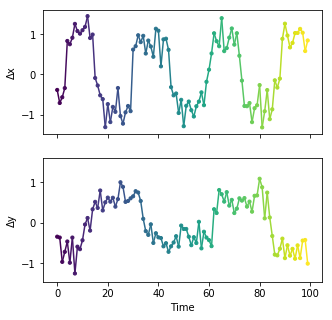

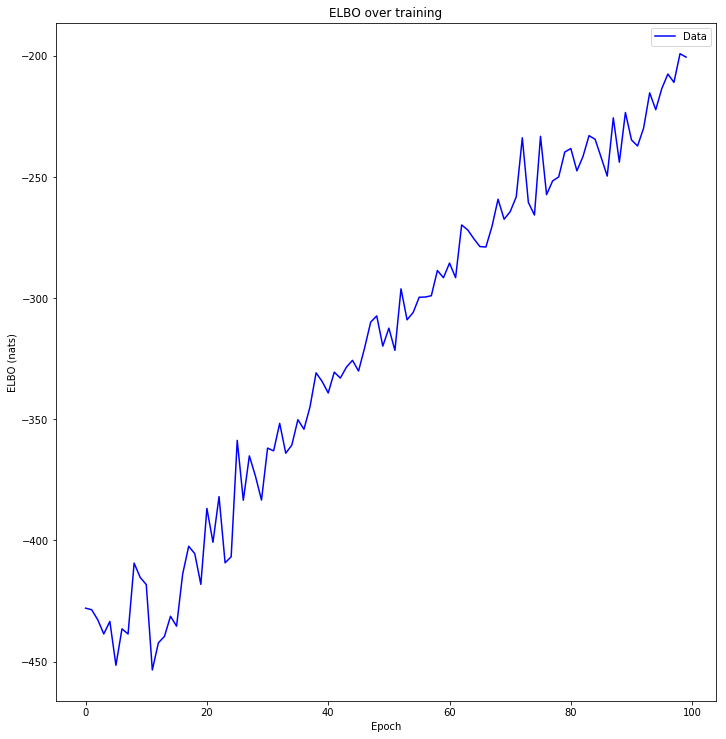

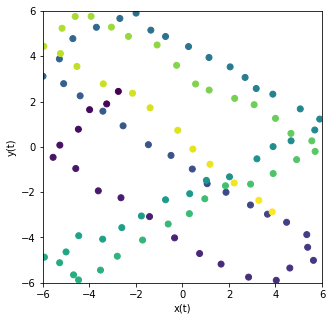

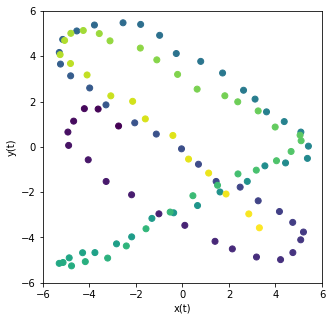

03/01/2019 18:04:33 MSE at time 0: tensor(2.3369)
03/01/2019 18:04:33 MSE at time 1: tensor(0.1867)
03/01/2019 18:04:33 MSE at time 2: tensor(0.0528)
03/01/2019 18:04:33 MSE at time 3: tensor(0.1689)
03/01/2019 18:04:33 MSE at time 4: tensor(0.4535)
03/01/2019 18:04:33 MSE at time 5: tensor(0.7221)
03/01/2019 18:04:33 MSE at time 6: tensor(0.4352)
03/01/2019 18:04:33 MSE at time 7: tensor(0.2839)
03/01/2019 18:04:33 MSE at time 8: tensor(0.2258)
03/01/2019 18:04:33 MSE at time 9: tensor(0.1778)
03/01/2019 18:04:33 MSE at time 10: tensor(0.4996)
03/01/2019 18:04:33 MSE at time 11: tensor(0.7309)
03/01/2019 18:04:33 MSE at time 12: tensor(0.6839)
03/01/2019 18:04:33 MSE at time 13: tensor(0.9034)
03/01/2019 18:04:33 MSE at time 14: tensor(0.8681)
03/01/2019 18:04:33 MSE at time 15: tensor(0.4815)
03/01/2019 18:04:33 MSE at time 16: tensor(1.1212)
03/01/2019 18:04:33 MSE at time 17: tensor(0.4854)
03/01/2019 18:04:33 MSE at time 18: tensor(0.6581)
03/01/2019 18:04:33 MSE at time 19: tenso

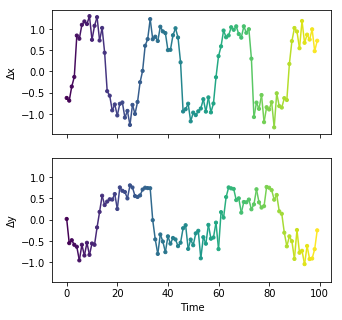

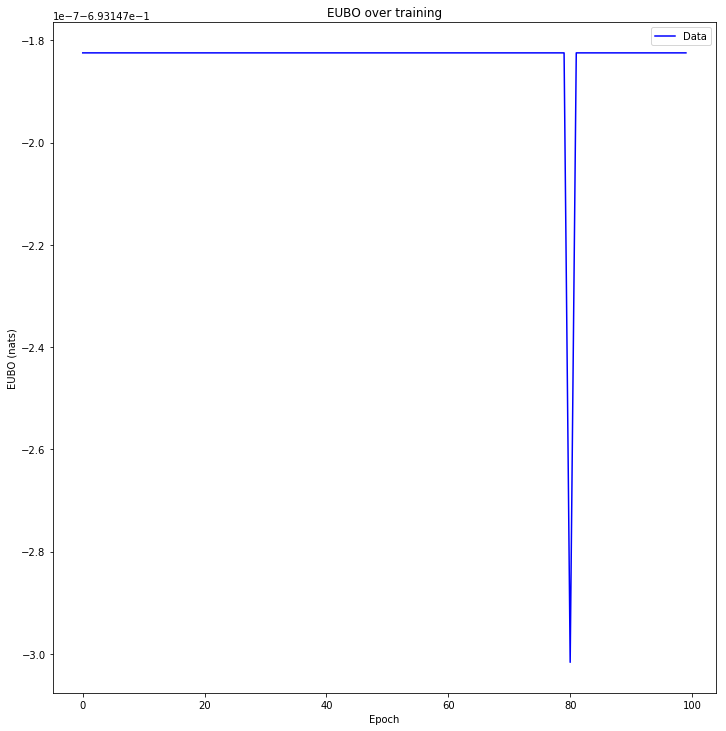

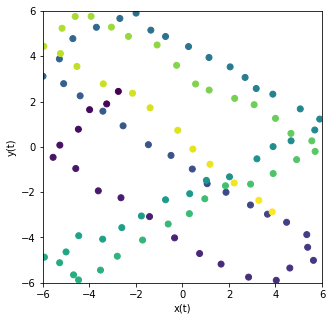

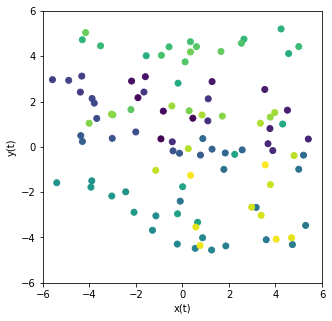

03/01/2019 18:04:51 MSE at time 0: tensor(7.7487)
03/01/2019 18:04:51 MSE at time 1: tensor(14.1344)
03/01/2019 18:04:51 MSE at time 2: tensor(10.0532)
03/01/2019 18:04:51 MSE at time 3: tensor(8.5131)
03/01/2019 18:04:51 MSE at time 4: tensor(17.5180)
03/01/2019 18:04:51 MSE at time 5: tensor(28.4086)
03/01/2019 18:04:51 MSE at time 6: tensor(49.0958)
03/01/2019 18:04:51 MSE at time 7: tensor(71.3024)
03/01/2019 18:04:51 MSE at time 8: tensor(66.1983)
03/01/2019 18:04:51 MSE at time 9: tensor(41.9381)
03/01/2019 18:04:51 MSE at time 10: tensor(52.1208)
03/01/2019 18:04:51 MSE at time 11: tensor(32.1517)
03/01/2019 18:04:51 MSE at time 12: tensor(30.0693)
03/01/2019 18:04:51 MSE at time 13: tensor(46.4713)
03/01/2019 18:04:51 MSE at time 14: tensor(58.2091)
03/01/2019 18:04:51 MSE at time 15: tensor(68.1111)
03/01/2019 18:04:51 MSE at time 16: tensor(108.3685)
03/01/2019 18:04:51 MSE at time 17: tensor(142.5033)
03/01/2019 18:04:51 MSE at time 18: tensor(166.4215)
03/01/2019 18:04:51 M

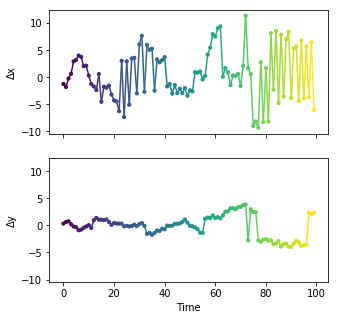

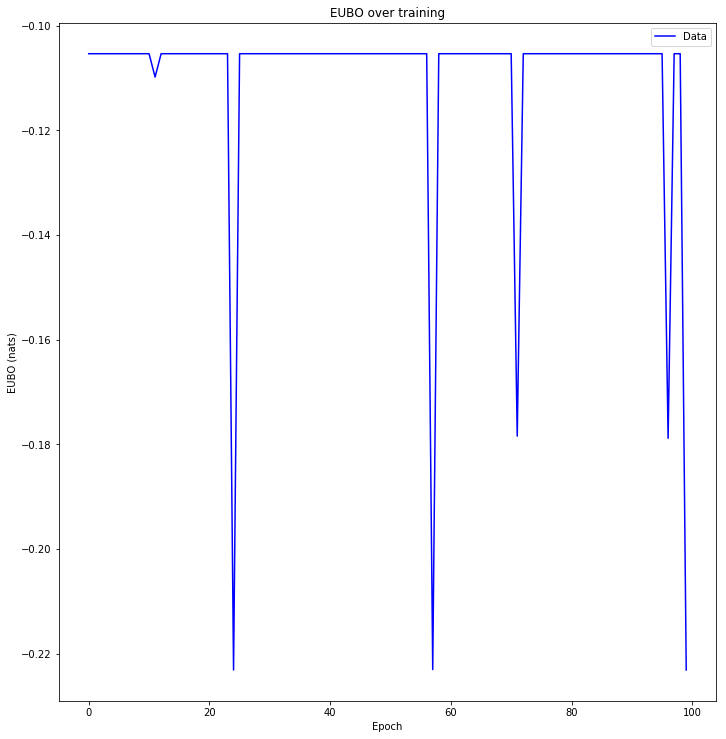

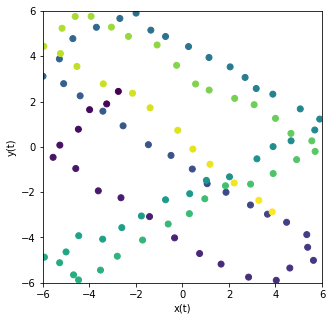

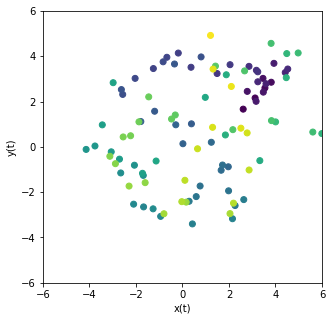

03/01/2019 18:05:10 MSE at time 0: tensor(29.4411)
03/01/2019 18:05:10 MSE at time 1: tensor(40.8206)
03/01/2019 18:05:10 MSE at time 2: tensor(57.7970)
03/01/2019 18:05:10 MSE at time 3: tensor(73.1207)
03/01/2019 18:05:10 MSE at time 4: tensor(85.0255)
03/01/2019 18:05:10 MSE at time 5: tensor(78.2100)
03/01/2019 18:05:10 MSE at time 6: tensor(76.4392)
03/01/2019 18:05:10 MSE at time 7: tensor(61.6656)
03/01/2019 18:05:10 MSE at time 8: tensor(78.4934)
03/01/2019 18:05:10 MSE at time 9: tensor(59.5157)
03/01/2019 18:05:10 MSE at time 10: tensor(75.9570)
03/01/2019 18:05:10 MSE at time 11: tensor(63.7557)
03/01/2019 18:05:10 MSE at time 12: tensor(82.4083)
03/01/2019 18:05:10 MSE at time 13: tensor(83.5121)
03/01/2019 18:05:10 MSE at time 14: tensor(90.6028)
03/01/2019 18:05:10 MSE at time 15: tensor(76.9476)
03/01/2019 18:05:10 MSE at time 16: tensor(85.2084)
03/01/2019 18:05:10 MSE at time 17: tensor(76.1271)
03/01/2019 18:05:10 MSE at time 18: tensor(79.3748)
03/01/2019 18:05:10 MS

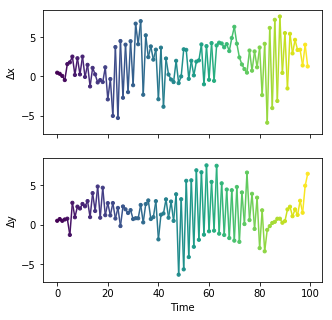

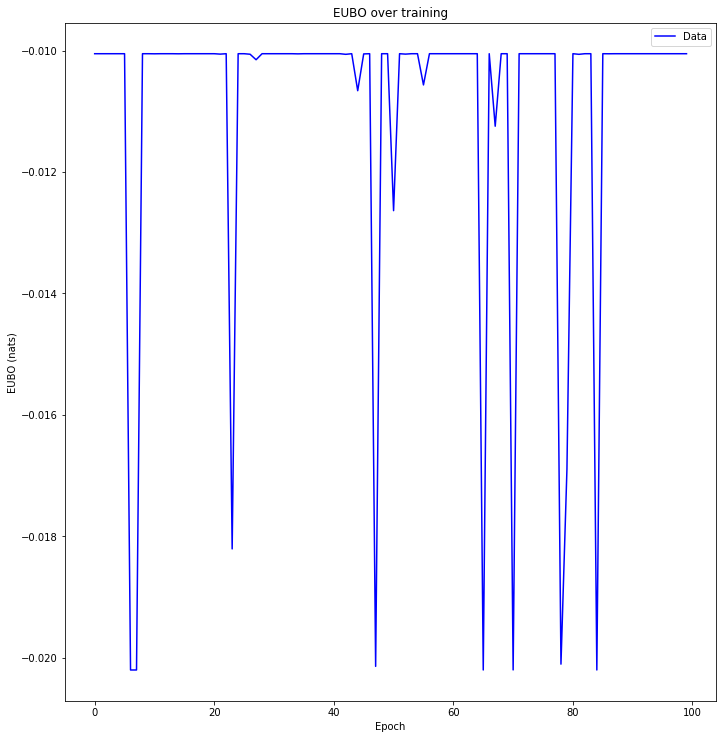

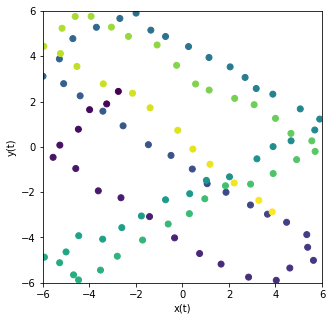

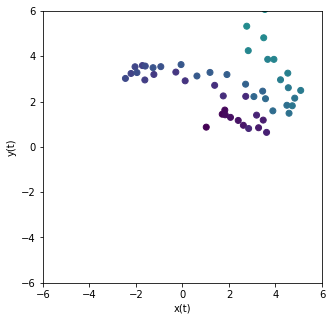

03/01/2019 18:05:30 MSE at time 0: tensor(16.7842)
03/01/2019 18:05:30 MSE at time 1: tensor(24.9033)
03/01/2019 18:05:30 MSE at time 2: tensor(33.8191)
03/01/2019 18:05:30 MSE at time 3: tensor(40.3109)
03/01/2019 18:05:30 MSE at time 4: tensor(55.3723)
03/01/2019 18:05:30 MSE at time 5: tensor(66.0530)
03/01/2019 18:05:30 MSE at time 6: tensor(55.6030)
03/01/2019 18:05:30 MSE at time 7: tensor(55.2718)
03/01/2019 18:05:30 MSE at time 8: tensor(49.1757)
03/01/2019 18:05:30 MSE at time 9: tensor(39.1584)
03/01/2019 18:05:30 MSE at time 10: tensor(41.7967)
03/01/2019 18:05:30 MSE at time 11: tensor(34.9086)
03/01/2019 18:05:30 MSE at time 12: tensor(55.9641)
03/01/2019 18:05:30 MSE at time 13: tensor(65.1901)
03/01/2019 18:05:30 MSE at time 14: tensor(81.1245)
03/01/2019 18:05:30 MSE at time 15: tensor(88.5728)
03/01/2019 18:05:30 MSE at time 16: tensor(104.1077)
03/01/2019 18:05:30 MSE at time 17: tensor(101.9625)
03/01/2019 18:05:30 MSE at time 18: tensor(95.1345)
03/01/2019 18:05:30 

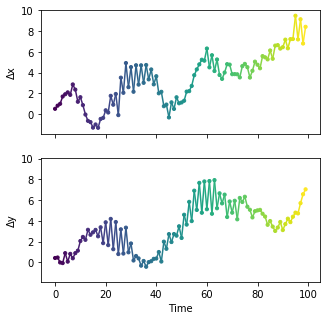

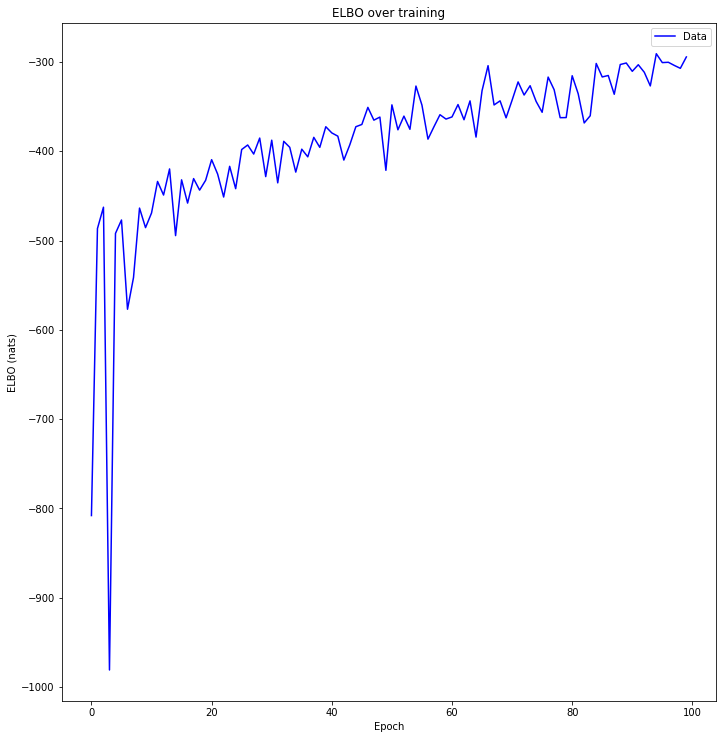

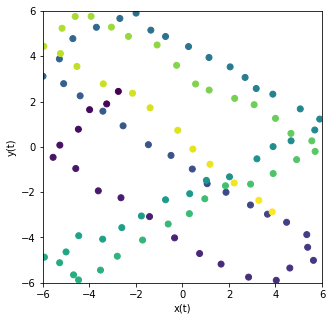

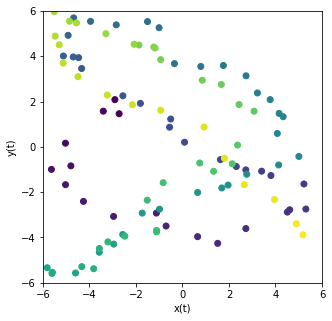

03/01/2019 18:05:49 MSE at time 0: tensor(0.9756)
03/01/2019 18:05:49 MSE at time 1: tensor(0.1602)
03/01/2019 18:05:49 MSE at time 2: tensor(0.3511)
03/01/2019 18:05:49 MSE at time 3: tensor(0.6896)
03/01/2019 18:05:49 MSE at time 4: tensor(1.0627)
03/01/2019 18:05:49 MSE at time 5: tensor(0.2895)
03/01/2019 18:05:49 MSE at time 6: tensor(0.7057)
03/01/2019 18:05:49 MSE at time 7: tensor(0.6259)
03/01/2019 18:05:49 MSE at time 8: tensor(0.7826)
03/01/2019 18:05:49 MSE at time 9: tensor(0.1102)
03/01/2019 18:05:49 MSE at time 10: tensor(0.4062)
03/01/2019 18:05:49 MSE at time 11: tensor(0.5626)
03/01/2019 18:05:49 MSE at time 12: tensor(0.8614)
03/01/2019 18:05:49 MSE at time 13: tensor(4.6134)
03/01/2019 18:05:49 MSE at time 14: tensor(10.0252)
03/01/2019 18:05:49 MSE at time 15: tensor(6.1049)
03/01/2019 18:05:49 MSE at time 16: tensor(5.2357)
03/01/2019 18:05:49 MSE at time 17: tensor(7.8359)
03/01/2019 18:05:49 MSE at time 18: tensor(9.1816)
03/01/2019 18:05:49 MSE at time 19: tens

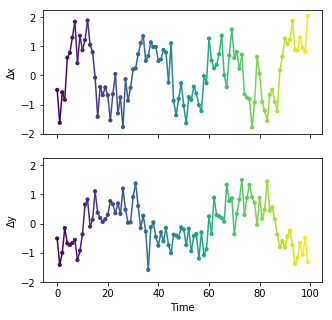

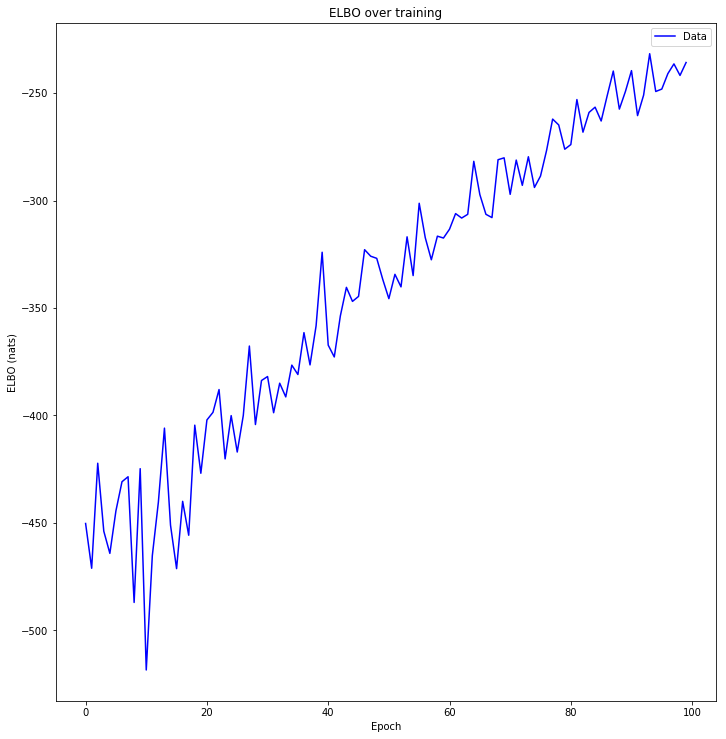

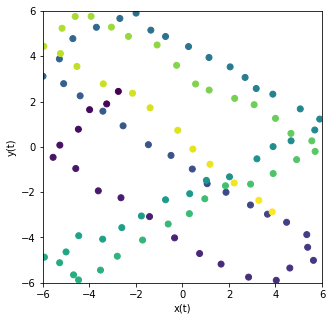

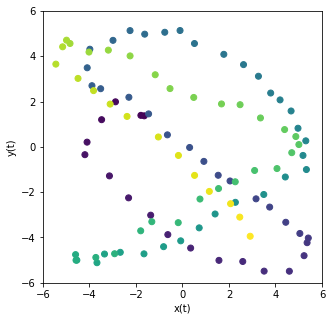

03/01/2019 18:06:06 MSE at time 0: tensor(2.4071)
03/01/2019 18:06:06 MSE at time 1: tensor(2.4205)
03/01/2019 18:06:06 MSE at time 2: tensor(1.3599)
03/01/2019 18:06:06 MSE at time 3: tensor(1.1760)
03/01/2019 18:06:06 MSE at time 4: tensor(1.3881)
03/01/2019 18:06:06 MSE at time 5: tensor(1.8853)
03/01/2019 18:06:06 MSE at time 6: tensor(2.2042)
03/01/2019 18:06:06 MSE at time 7: tensor(1.7920)
03/01/2019 18:06:06 MSE at time 8: tensor(2.2266)
03/01/2019 18:06:06 MSE at time 9: tensor(1.2517)
03/01/2019 18:06:06 MSE at time 10: tensor(0.6798)
03/01/2019 18:06:06 MSE at time 11: tensor(0.7844)
03/01/2019 18:06:06 MSE at time 12: tensor(0.8833)
03/01/2019 18:06:06 MSE at time 13: tensor(0.5174)
03/01/2019 18:06:06 MSE at time 14: tensor(0.4779)
03/01/2019 18:06:06 MSE at time 15: tensor(0.6733)
03/01/2019 18:06:06 MSE at time 16: tensor(0.6825)
03/01/2019 18:06:06 MSE at time 17: tensor(0.1677)
03/01/2019 18:06:06 MSE at time 18: tensor(0.0913)
03/01/2019 18:06:06 MSE at time 19: tenso

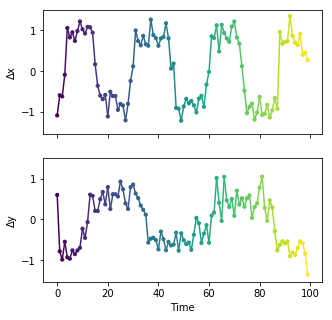

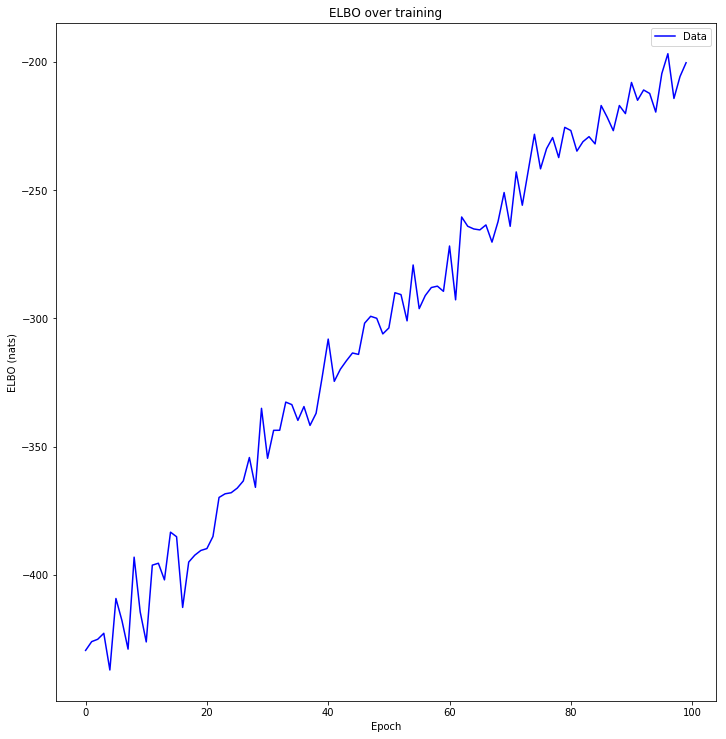

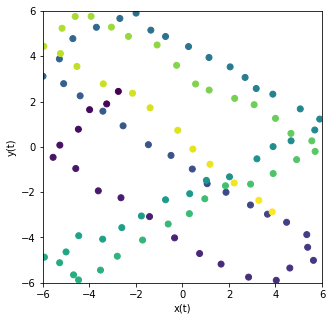

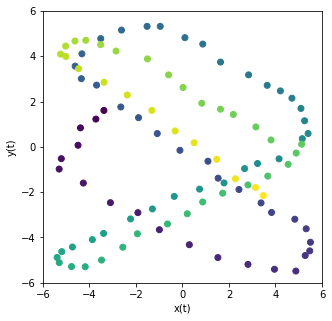

03/01/2019 18:06:26 MSE at time 0: tensor(1.0943)
03/01/2019 18:06:26 MSE at time 1: tensor(0.6661)
03/01/2019 18:06:26 MSE at time 2: tensor(0.7970)
03/01/2019 18:06:26 MSE at time 3: tensor(0.5022)
03/01/2019 18:06:26 MSE at time 4: tensor(0.3610)
03/01/2019 18:06:26 MSE at time 5: tensor(0.3374)
03/01/2019 18:06:26 MSE at time 6: tensor(0.5200)
03/01/2019 18:06:26 MSE at time 7: tensor(0.5458)
03/01/2019 18:06:26 MSE at time 8: tensor(0.9632)
03/01/2019 18:06:26 MSE at time 9: tensor(0.5149)
03/01/2019 18:06:26 MSE at time 10: tensor(0.4941)
03/01/2019 18:06:26 MSE at time 11: tensor(0.6509)
03/01/2019 18:06:26 MSE at time 12: tensor(1.3383)
03/01/2019 18:06:26 MSE at time 13: tensor(1.3606)
03/01/2019 18:06:26 MSE at time 14: tensor(0.8765)
03/01/2019 18:06:26 MSE at time 15: tensor(0.7444)
03/01/2019 18:06:26 MSE at time 16: tensor(0.2000)
03/01/2019 18:06:26 MSE at time 17: tensor(0.0634)
03/01/2019 18:06:26 MSE at time 18: tensor(0.0671)
03/01/2019 18:06:26 MSE at time 19: tenso

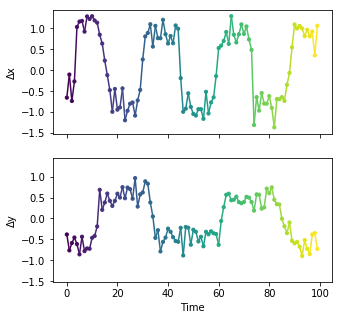

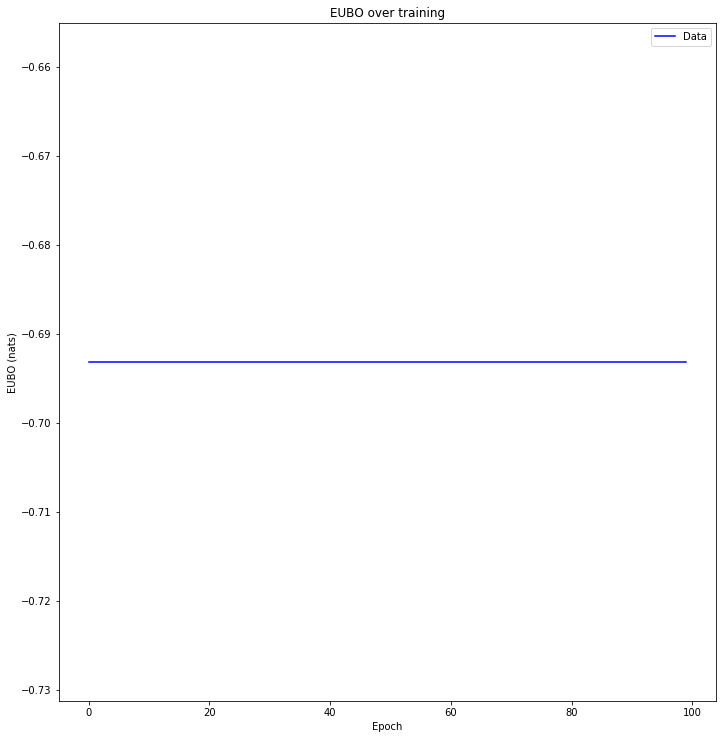

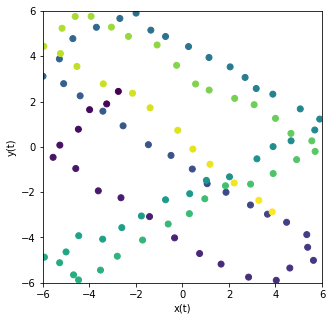

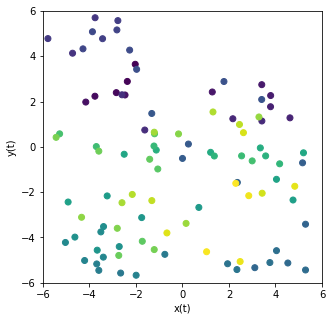

03/01/2019 18:06:46 MSE at time 0: tensor(1.9579)
03/01/2019 18:06:46 MSE at time 1: tensor(1.7733)
03/01/2019 18:06:46 MSE at time 2: tensor(1.8851)
03/01/2019 18:06:46 MSE at time 3: tensor(2.6302)
03/01/2019 18:06:46 MSE at time 4: tensor(4.8598)
03/01/2019 18:06:46 MSE at time 5: tensor(17.1480)
03/01/2019 18:06:46 MSE at time 6: tensor(45.8902)
03/01/2019 18:06:46 MSE at time 7: tensor(71.3936)
03/01/2019 18:06:46 MSE at time 8: tensor(61.7983)
03/01/2019 18:06:46 MSE at time 9: tensor(50.6214)
03/01/2019 18:06:46 MSE at time 10: tensor(52.7062)
03/01/2019 18:06:46 MSE at time 11: tensor(37.4548)
03/01/2019 18:06:46 MSE at time 12: tensor(42.9956)
03/01/2019 18:06:46 MSE at time 13: tensor(62.1180)
03/01/2019 18:06:46 MSE at time 14: tensor(111.1237)
03/01/2019 18:06:46 MSE at time 15: tensor(177.2554)
03/01/2019 18:06:46 MSE at time 16: tensor(202.9147)
03/01/2019 18:06:46 MSE at time 17: tensor(209.6805)
03/01/2019 18:06:46 MSE at time 18: tensor(155.2898)
03/01/2019 18:06:46 MS

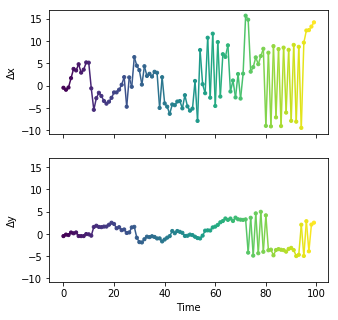

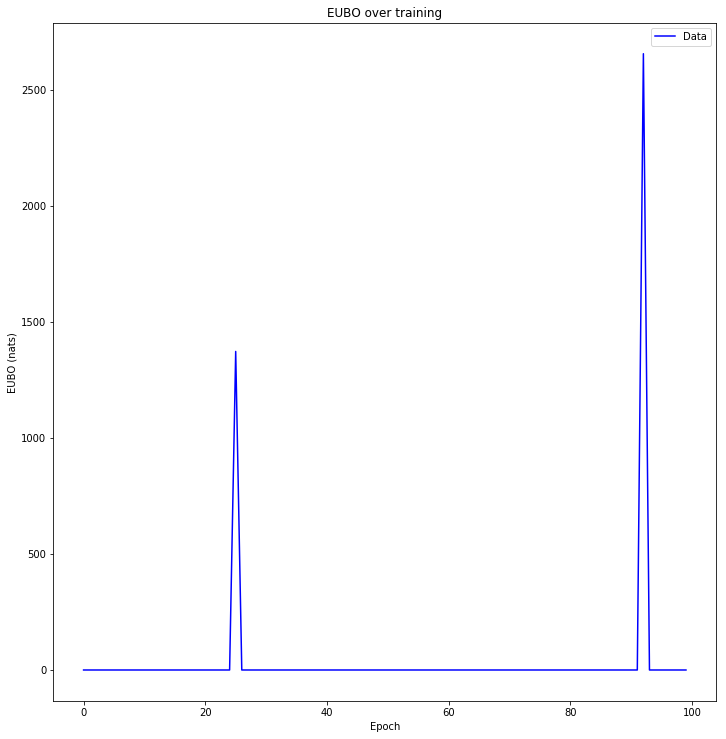

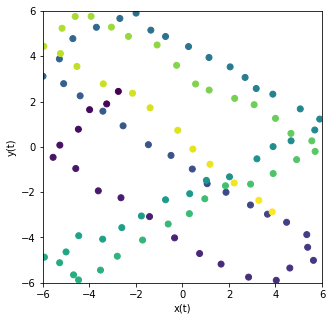

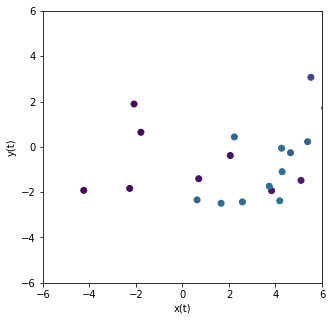

03/01/2019 18:07:06 MSE at time 0: tensor(4.2002)
03/01/2019 18:07:06 MSE at time 1: tensor(1.3844)
03/01/2019 18:07:06 MSE at time 2: tensor(12.7497)
03/01/2019 18:07:06 MSE at time 3: tensor(11.7032)
03/01/2019 18:07:06 MSE at time 4: tensor(37.8834)
03/01/2019 18:07:06 MSE at time 5: tensor(58.0748)
03/01/2019 18:07:06 MSE at time 6: tensor(71.8671)
03/01/2019 18:07:06 MSE at time 7: tensor(76.2299)
03/01/2019 18:07:06 MSE at time 8: tensor(80.5501)
03/01/2019 18:07:06 MSE at time 9: tensor(74.4490)
03/01/2019 18:07:06 MSE at time 10: tensor(81.1909)
03/01/2019 18:07:06 MSE at time 11: tensor(91.2414)
03/01/2019 18:07:06 MSE at time 12: tensor(107.7961)
03/01/2019 18:07:06 MSE at time 13: tensor(93.1815)
03/01/2019 18:07:06 MSE at time 14: tensor(123.8709)
03/01/2019 18:07:06 MSE at time 15: tensor(81.6924)
03/01/2019 18:07:06 MSE at time 16: tensor(73.9784)
03/01/2019 18:07:06 MSE at time 17: tensor(56.3889)
03/01/2019 18:07:06 MSE at time 18: tensor(49.1541)
03/01/2019 18:07:06 MS

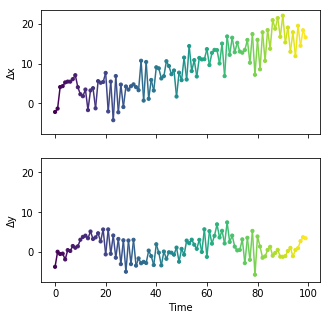

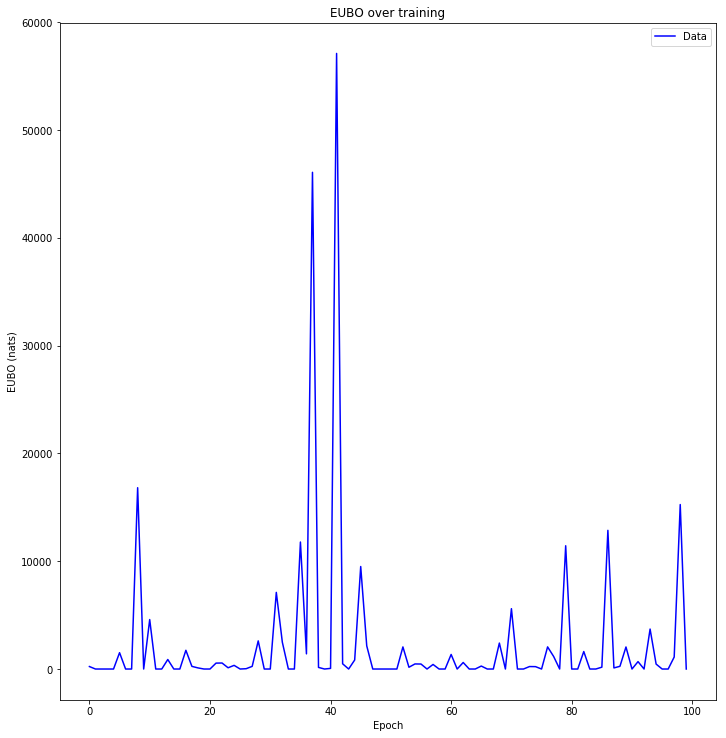

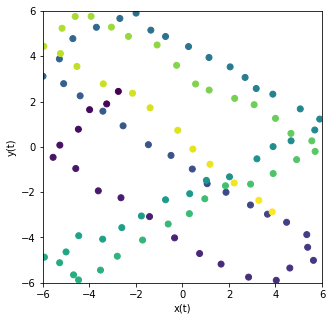

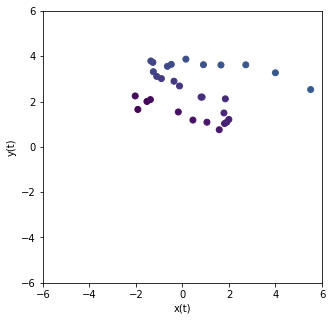

03/01/2019 18:07:26 MSE at time 0: tensor(1.3395)
03/01/2019 18:07:26 MSE at time 1: tensor(3.0079)
03/01/2019 18:07:26 MSE at time 2: tensor(4.2143)
03/01/2019 18:07:26 MSE at time 3: tensor(11.3074)
03/01/2019 18:07:26 MSE at time 4: tensor(28.1153)
03/01/2019 18:07:26 MSE at time 5: tensor(38.8641)
03/01/2019 18:07:26 MSE at time 6: tensor(36.0089)
03/01/2019 18:07:26 MSE at time 7: tensor(34.3213)
03/01/2019 18:07:26 MSE at time 8: tensor(30.5641)
03/01/2019 18:07:26 MSE at time 9: tensor(30.0307)
03/01/2019 18:07:26 MSE at time 10: tensor(31.0859)
03/01/2019 18:07:26 MSE at time 11: tensor(39.6213)
03/01/2019 18:07:26 MSE at time 12: tensor(53.2641)
03/01/2019 18:07:26 MSE at time 13: tensor(67.1833)
03/01/2019 18:07:26 MSE at time 14: tensor(75.9086)
03/01/2019 18:07:26 MSE at time 15: tensor(87.1086)
03/01/2019 18:07:26 MSE at time 16: tensor(98.5105)
03/01/2019 18:07:26 MSE at time 17: tensor(95.0307)
03/01/2019 18:07:26 MSE at time 18: tensor(90.4336)
03/01/2019 18:07:26 MSE a

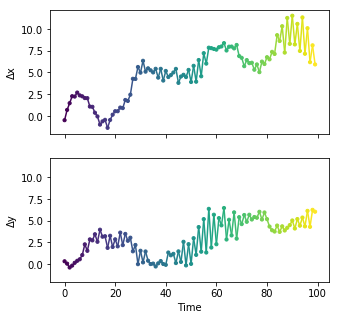

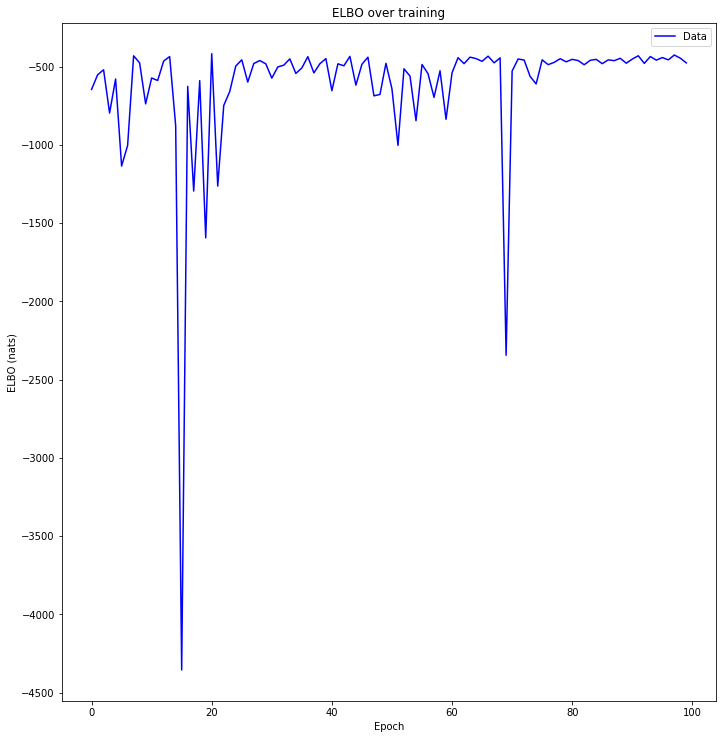

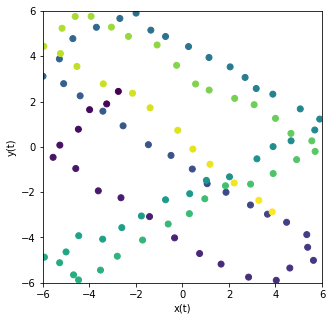

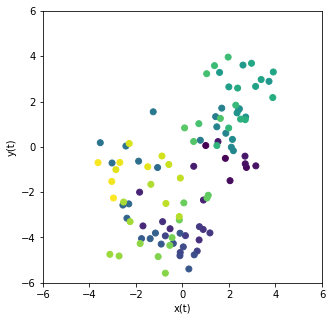

03/01/2019 18:07:50 MSE at time 0: tensor(19.8417)
03/01/2019 18:07:50 MSE at time 1: tensor(31.8320)
03/01/2019 18:07:50 MSE at time 2: tensor(51.9946)
03/01/2019 18:07:50 MSE at time 3: tensor(47.7187)
03/01/2019 18:07:50 MSE at time 4: tensor(64.2718)
03/01/2019 18:07:50 MSE at time 5: tensor(76.1763)
03/01/2019 18:07:50 MSE at time 6: tensor(53.2859)
03/01/2019 18:07:50 MSE at time 7: tensor(31.2356)
03/01/2019 18:07:50 MSE at time 8: tensor(11.7224)
03/01/2019 18:07:51 MSE at time 9: tensor(5.9081)
03/01/2019 18:07:51 MSE at time 10: tensor(6.3340)
03/01/2019 18:07:51 MSE at time 11: tensor(7.4170)
03/01/2019 18:07:51 MSE at time 12: tensor(7.2497)
03/01/2019 18:07:51 MSE at time 13: tensor(7.2280)
03/01/2019 18:07:51 MSE at time 14: tensor(30.6071)
03/01/2019 18:07:51 MSE at time 15: tensor(16.7888)
03/01/2019 18:07:51 MSE at time 16: tensor(21.2863)
03/01/2019 18:07:51 MSE at time 17: tensor(22.5010)
03/01/2019 18:07:51 MSE at time 18: tensor(27.2356)
03/01/2019 18:07:51 MSE at 

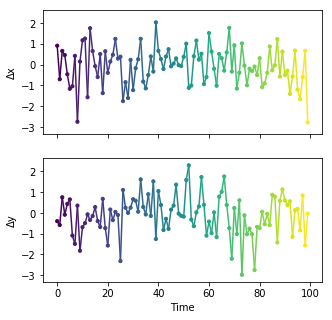

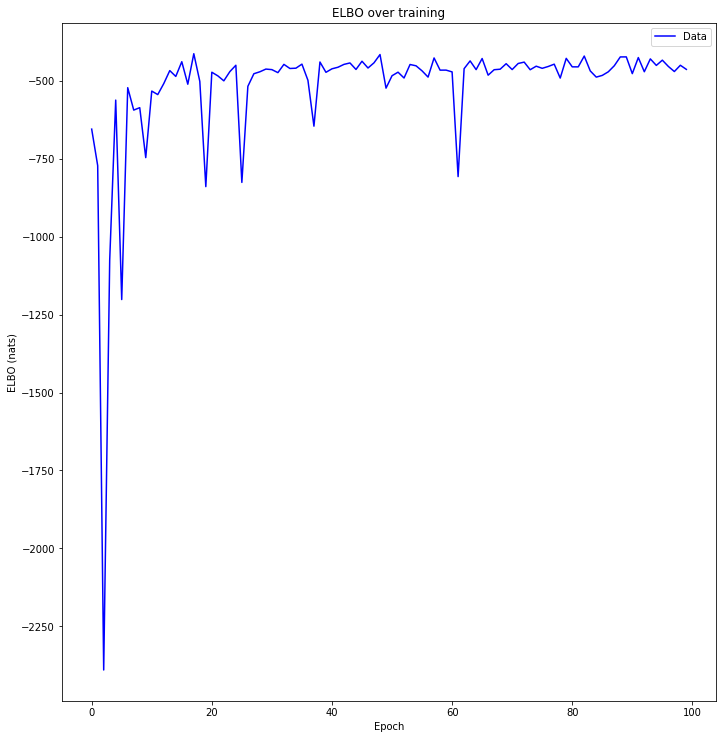

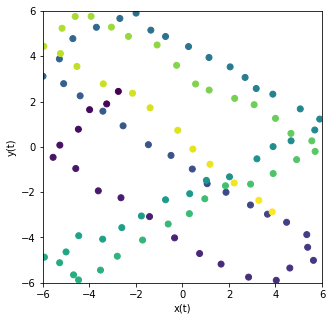

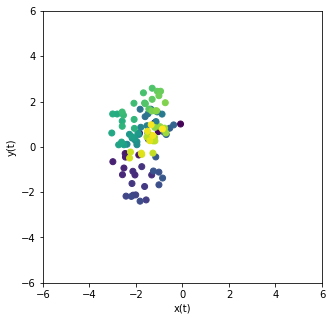

03/01/2019 18:08:13 MSE at time 0: tensor(5.7143)
03/01/2019 18:08:13 MSE at time 1: tensor(10.8818)
03/01/2019 18:08:13 MSE at time 2: tensor(8.4061)
03/01/2019 18:08:13 MSE at time 3: tensor(11.8265)
03/01/2019 18:08:13 MSE at time 4: tensor(17.4862)
03/01/2019 18:08:13 MSE at time 5: tensor(14.9371)
03/01/2019 18:08:13 MSE at time 6: tensor(7.7032)
03/01/2019 18:08:13 MSE at time 7: tensor(4.0484)
03/01/2019 18:08:13 MSE at time 8: tensor(3.2576)
03/01/2019 18:08:13 MSE at time 9: tensor(8.3661)
03/01/2019 18:08:13 MSE at time 10: tensor(14.2539)
03/01/2019 18:08:13 MSE at time 11: tensor(23.1141)
03/01/2019 18:08:13 MSE at time 12: tensor(29.2013)
03/01/2019 18:08:13 MSE at time 13: tensor(46.5928)
03/01/2019 18:08:13 MSE at time 14: tensor(50.3434)
03/01/2019 18:08:13 MSE at time 15: tensor(60.5775)
03/01/2019 18:08:13 MSE at time 16: tensor(72.4153)
03/01/2019 18:08:13 MSE at time 17: tensor(56.3735)
03/01/2019 18:08:13 MSE at time 18: tensor(50.0811)
03/01/2019 18:08:13 MSE at t

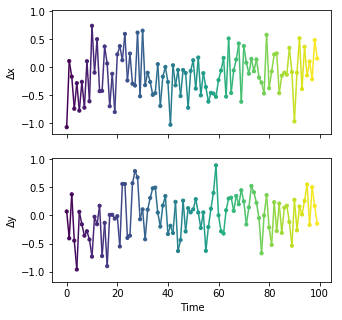

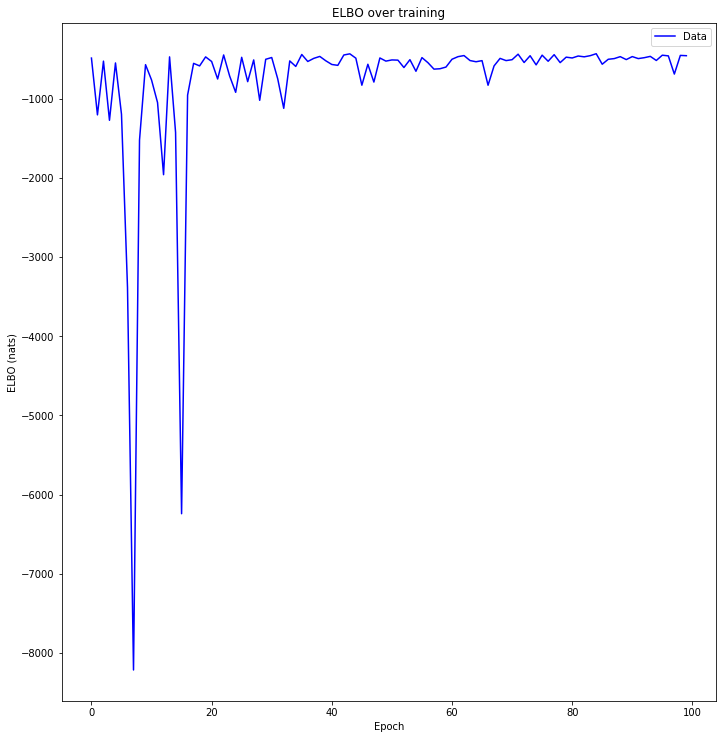

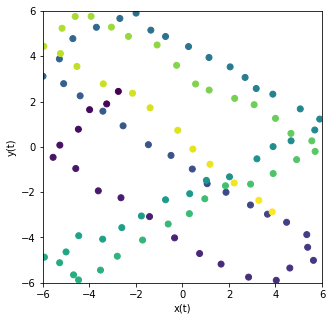

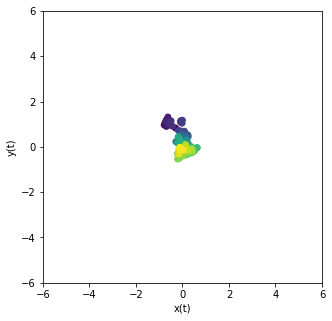

03/01/2019 18:08:41 MSE at time 0: tensor(12.7785)
03/01/2019 18:08:41 MSE at time 1: tensor(9.8981)
03/01/2019 18:08:41 MSE at time 2: tensor(10.8782)
03/01/2019 18:08:41 MSE at time 3: tensor(15.1172)
03/01/2019 18:08:41 MSE at time 4: tensor(20.9514)
03/01/2019 18:08:41 MSE at time 5: tensor(25.4899)
03/01/2019 18:08:41 MSE at time 6: tensor(18.6333)
03/01/2019 18:08:41 MSE at time 7: tensor(18.2896)
03/01/2019 18:08:41 MSE at time 8: tensor(16.7669)
03/01/2019 18:08:41 MSE at time 9: tensor(18.6687)
03/01/2019 18:08:41 MSE at time 10: tensor(26.7187)
03/01/2019 18:08:41 MSE at time 11: tensor(34.3619)
03/01/2019 18:08:41 MSE at time 12: tensor(43.5811)
03/01/2019 18:08:41 MSE at time 13: tensor(58.7399)
03/01/2019 18:08:41 MSE at time 14: tensor(66.3353)
03/01/2019 18:08:41 MSE at time 15: tensor(63.3593)
03/01/2019 18:08:41 MSE at time 16: tensor(70.5751)
03/01/2019 18:08:41 MSE at time 17: tensor(60.5031)
03/01/2019 18:08:41 MSE at time 18: tensor(52.9745)
03/01/2019 18:08:41 MSE

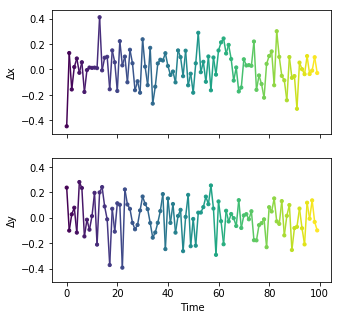

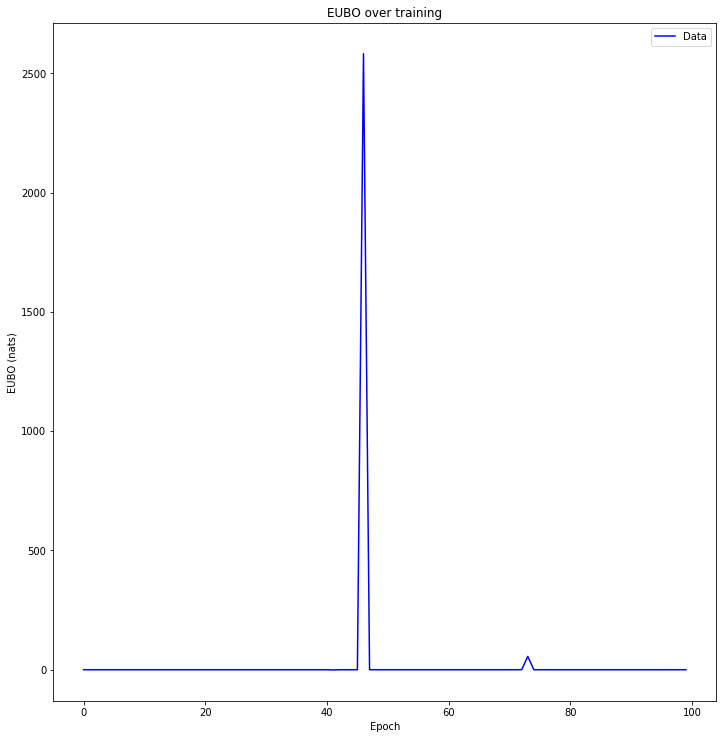

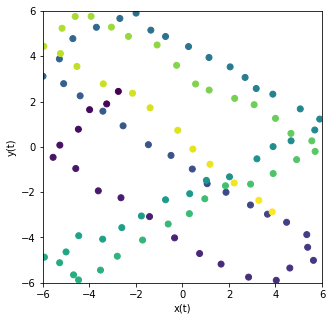

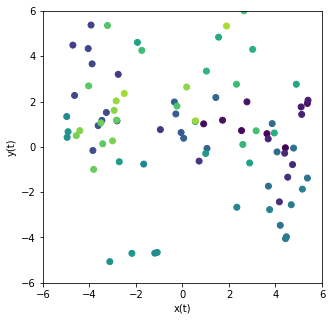

03/01/2019 18:09:03 MSE at time 0: tensor(57.8235)
03/01/2019 18:09:03 MSE at time 1: tensor(49.2544)
03/01/2019 18:09:03 MSE at time 2: tensor(43.5431)
03/01/2019 18:09:03 MSE at time 3: tensor(29.0973)
03/01/2019 18:09:03 MSE at time 4: tensor(50.1758)
03/01/2019 18:09:03 MSE at time 5: tensor(75.5102)
03/01/2019 18:09:03 MSE at time 6: tensor(107.4600)
03/01/2019 18:09:03 MSE at time 7: tensor(89.8121)
03/01/2019 18:09:03 MSE at time 8: tensor(83.2325)
03/01/2019 18:09:03 MSE at time 9: tensor(63.1841)
03/01/2019 18:09:03 MSE at time 10: tensor(35.2926)
03/01/2019 18:09:03 MSE at time 11: tensor(33.0016)
03/01/2019 18:09:03 MSE at time 12: tensor(28.7646)
03/01/2019 18:09:03 MSE at time 13: tensor(22.3053)
03/01/2019 18:09:03 MSE at time 14: tensor(12.0134)
03/01/2019 18:09:03 MSE at time 15: tensor(37.5137)
03/01/2019 18:09:03 MSE at time 16: tensor(76.6686)
03/01/2019 18:09:03 MSE at time 17: tensor(124.6748)
03/01/2019 18:09:03 MSE at time 18: tensor(171.2123)
03/01/2019 18:09:03

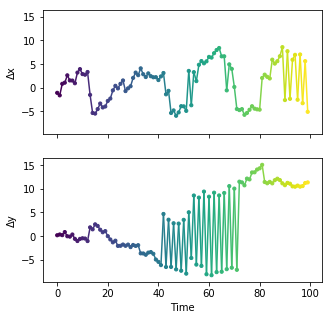

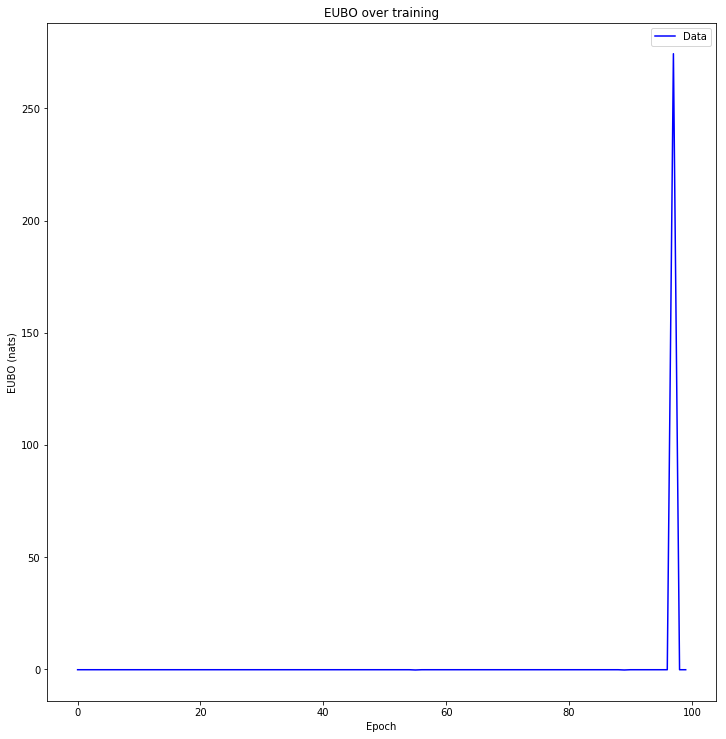

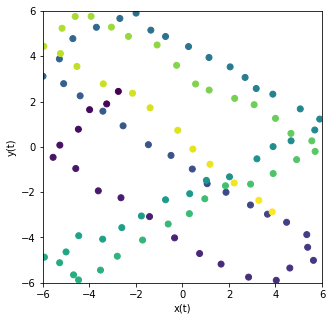

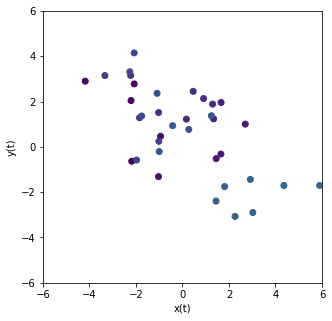

03/01/2019 18:09:25 MSE at time 0: tensor(9.8382)
03/01/2019 18:09:25 MSE at time 1: tensor(1.1204)
03/01/2019 18:09:25 MSE at time 2: tensor(1.6181)
03/01/2019 18:09:25 MSE at time 3: tensor(9.7674)
03/01/2019 18:09:25 MSE at time 4: tensor(18.9436)
03/01/2019 18:09:25 MSE at time 5: tensor(21.2793)
03/01/2019 18:09:25 MSE at time 6: tensor(36.6671)
03/01/2019 18:09:25 MSE at time 7: tensor(30.4294)
03/01/2019 18:09:25 MSE at time 8: tensor(39.1400)
03/01/2019 18:09:25 MSE at time 9: tensor(26.2033)
03/01/2019 18:09:25 MSE at time 10: tensor(39.7203)
03/01/2019 18:09:25 MSE at time 11: tensor(35.5153)
03/01/2019 18:09:25 MSE at time 12: tensor(50.0390)
03/01/2019 18:09:25 MSE at time 13: tensor(65.9083)
03/01/2019 18:09:25 MSE at time 14: tensor(82.3782)
03/01/2019 18:09:25 MSE at time 15: tensor(78.9518)
03/01/2019 18:09:25 MSE at time 16: tensor(128.4259)
03/01/2019 18:09:25 MSE at time 17: tensor(84.9793)
03/01/2019 18:09:25 MSE at time 18: tensor(124.6948)
03/01/2019 18:09:25 MSE 

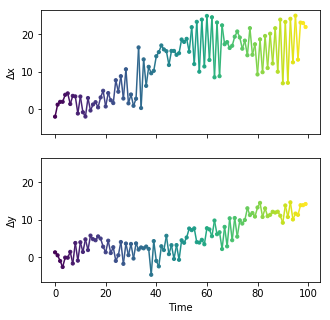

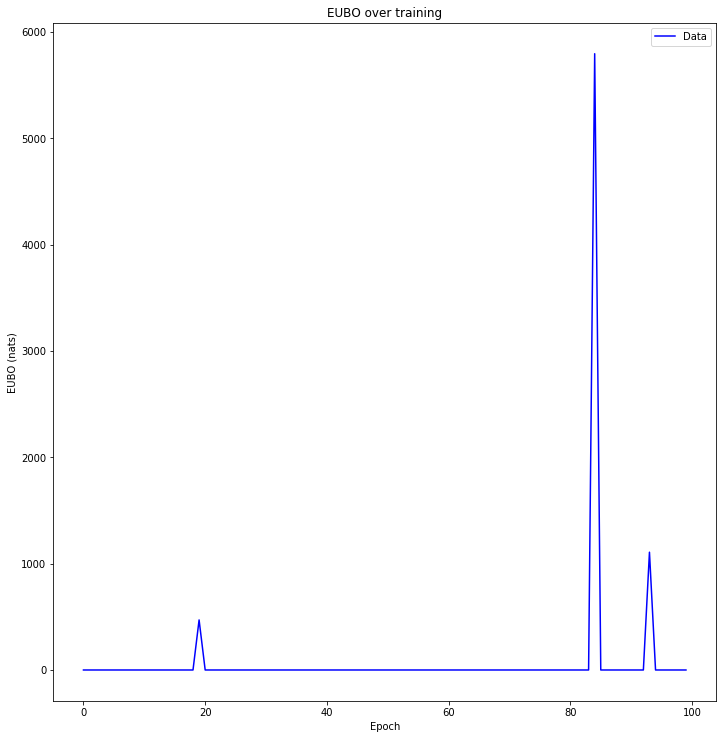

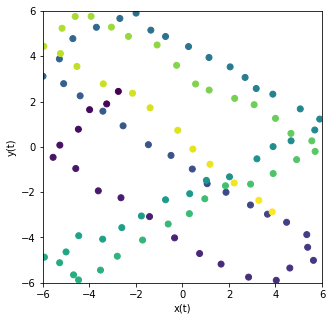

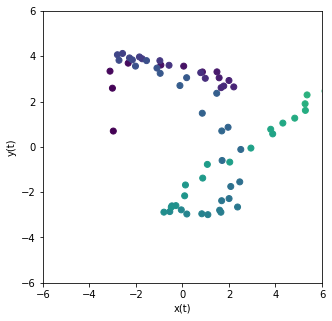

03/01/2019 18:09:49 MSE at time 0: tensor(3.1150)
03/01/2019 18:09:49 MSE at time 1: tensor(0.5434)
03/01/2019 18:09:49 MSE at time 2: tensor(3.6638)
03/01/2019 18:09:49 MSE at time 3: tensor(13.0940)
03/01/2019 18:09:49 MSE at time 4: tensor(31.3996)
03/01/2019 18:09:49 MSE at time 5: tensor(47.7574)
03/01/2019 18:09:49 MSE at time 6: tensor(47.8678)
03/01/2019 18:09:49 MSE at time 7: tensor(53.6325)
03/01/2019 18:09:49 MSE at time 8: tensor(45.8684)
03/01/2019 18:09:49 MSE at time 9: tensor(47.7731)
03/01/2019 18:09:49 MSE at time 10: tensor(50.8986)
03/01/2019 18:09:49 MSE at time 11: tensor(54.4768)
03/01/2019 18:09:49 MSE at time 12: tensor(61.8251)
03/01/2019 18:09:49 MSE at time 13: tensor(80.5261)
03/01/2019 18:09:49 MSE at time 14: tensor(94.6167)
03/01/2019 18:09:49 MSE at time 15: tensor(107.1001)
03/01/2019 18:09:49 MSE at time 16: tensor(121.3409)
03/01/2019 18:09:49 MSE at time 17: tensor(119.9366)
03/01/2019 18:09:49 MSE at time 18: tensor(113.3435)
03/01/2019 18:09:49 M

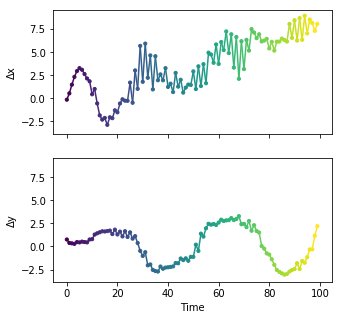

In [25]:
results_dict = experiment()

In [26]:
torch.save(results_dict, 'examples/dynamical_ball/experiment_results.data')